In [38]:
!pip install kagglehub tensorflow matplotlib seaborn scikit-learn pillow

In [39]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import json
from PIL import Image
import kagglehub

In [46]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pacificrm/skindiseasedataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'skindiseasedataset' dataset.
Path to dataset files: /kaggle/input/skindiseasedataset


#Check dataset

In [47]:
def explore_directory_structure_detailed(base_path):
    print(f"\nKHÁM PHÁ CHI TIẾT CẤU TRÚC THƯ MỤC: {base_path}")

    if not os.path.exists(base_path):
        print("Thư mục không tồn tại")
        return

    print("\nCấu trúc thư mục (2 level đầu tiên):")
    for root, dirs, files in os.walk(base_path):
        level = root.replace(base_path, '').count(os.sep)
        if level <= 2:  # Chỉ hiển thị 2 level đầu
            indent = '  ' * level
            print(f'{indent} {os.path.basename(root)}/')

            # Hiển thị thư mục con
            sub_indent = '  ' * (level + 1)
            for dir_name in dirs[:10]:
                print(f'{sub_indent} {dir_name}/')
            if len(dirs) > 10:
                print(f'{sub_indent}... và {len(dirs) - 10} thư mục khác')

            # Hiển thị file
            for file_name in files[:5]:
                print(f'{sub_indent} {file_name}')
            if len(files) > 5:
                print(f'{sub_indent}... và {len(files) - 5} file khác')
            print()  # Xuống dòng giữa các thư mục
# Khám phá chi tiết
explore_directory_structure_detailed(path)
def find_data_directories(base_path):
    """Tìm tất cả các thư mục có thể chứa dữ liệu train/test"""
    possible_train_dirs = []
    possible_test_dirs = []

    for root, dirs, files in os.walk(base_path):
        # Kiểm tra nếu thư mục có vẻ chứa dữ liệu ảnh
        if any(keyword in root.lower() for keyword in ['train', 'training']):
            possible_train_dirs.append(root)
        elif any(keyword in root.lower() for keyword in ['test', 'testing', 'val', 'validation']):
            possible_test_dirs.append(root)

        # Kiểm tra nếu thư mục có nhiều thư mục con (có thể là classes)
        if len(dirs) > 5:
            print(f"Thư mục có nhiều lớp tiềm năng: {root} ({len(dirs)} thư mục con)")

    return possible_train_dirs, possible_test_dirs

print("\nĐang tìm thư mục dữ liệu...")
possible_train_dirs, possible_test_dirs = find_data_directories(path)

print(f"\nCác thư mục train tiềm năng:")
for dir_path in possible_train_dirs[:5]:
    print(f"  - {dir_path}")

print(f"\nCác thư mục test tiềm năng:")
for dir_path in possible_test_dirs[:5]:
    print(f"  - {dir_path}")
dermnet_path = os.path.join(path, 'dermnet')
if os.path.exists(dermnet_path):
    print(f"\n Kiểm tra thư mục 'dermnet': {dermnet_path}")
    explore_directory_structure_detailed(dermnet_path)


KHÁM PHÁ CHI TIẾT CẤU TRÚC THƯ MỤC: /kaggle/input/skindiseasedataset

Cấu trúc thư mục (2 level đầu tiên):
 skindiseasedataset/
   SkinDisease/
   Readme.md

   SkinDisease/
     SkinDisease/

     SkinDisease/
       test/
       train/


Đang tìm thư mục dữ liệu...
Thư mục có nhiều lớp tiềm năng: /kaggle/input/skindiseasedataset/SkinDisease/SkinDisease/test (22 thư mục con)
Thư mục có nhiều lớp tiềm năng: /kaggle/input/skindiseasedataset/SkinDisease/SkinDisease/train (22 thư mục con)

Các thư mục train tiềm năng:
  - /kaggle/input/skindiseasedataset/SkinDisease/SkinDisease/train
  - /kaggle/input/skindiseasedataset/SkinDisease/SkinDisease/train/Benign_tumors
  - /kaggle/input/skindiseasedataset/SkinDisease/SkinDisease/train/Unknown_Normal
  - /kaggle/input/skindiseasedataset/SkinDisease/SkinDisease/train/Tinea
  - /kaggle/input/skindiseasedataset/SkinDisease/SkinDisease/train/Eczema

Các thư mục test tiềm năng:
  - /kaggle/input/skindiseasedataset/SkinDisease/SkinDisease/test
  - /k

#Path final

In [48]:
def find_correct_paths(base_path):
    """Tìm đường dẫn chính xác cho train và test data"""

    # Các pattern có thể
    patterns = [

        {'train': ['train'], 'test': ['test']},

        {'train': ['train'], 'test': ['test', 'valid', 'validation']},

        {'train': ['data', 'train'], 'test': ['data', 'test']},
    ]

    for pattern in patterns:
        train_candidates = pattern['train']
        test_candidates = pattern['test']

        for train_candidate in train_candidates:
            for test_candidate in test_candidates:
                train_path = base_path
                test_path = base_path

                # Thử các combination
                for part in train_candidate.split('/'):
                    train_path = os.path.join(train_path, part)
                for part in test_candidate.split('/'):
                    test_path = os.path.join(test_path, part)

                if os.path.exists(train_path) and os.path.exists(test_path):
                    # Kiểm tra xem có chứa thư mục con không (classes)
                    train_subdirs = [d for d in os.listdir(train_path)
                                   if os.path.isdir(os.path.join(train_path, d))]
                    test_subdirs = [d for d in os.listdir(test_path)
                                  if os.path.isdir(os.path.join(test_path, d))]

                    if len(train_subdirs) > 0 and len(test_subdirs) > 0:
                        print(f" Tìm thấy cấu trúc phù hợp!")
                        print(f"   Train: {train_path} ({len(train_subdirs)} classes)")
                        print(f"   Test: {test_path} ({len(test_subdirs)} classes)")
                        return train_path, test_path

    # Nếu không tìm thấy bằng pattern, thử tìm thủ công
    print("\nTìm kiếm thủ công...")
    for root, dirs, files in os.walk(base_path):
        if len(dirs) > 10:
            print(f"Thư mục có {len(dirs)} lớp: {root}")
            parent_dir = os.path.dirname(root)
            sibling_dirs = [d for d in os.listdir(parent_dir)
                          if os.path.isdir(os.path.join(parent_dir, d))] if parent_dir != base_path else []

            if len(sibling_dirs) >= 2:
                print(f"   Các thư mục cùng cấp: {sibling_dirs}")

    return None, None

print("\n Đang tìm đường dẫn chính xác...")
train_path, test_path = find_correct_paths(path)
if train_path is None:
    print("\nThử đường dẫn trực tiếp...")
    direct_paths = [
        path,
        os.path.join(path, 'dermnet'),
        os.path.join(path, 'data'),
        os.path.join(path, 'DermNet'),
    ]

    for base in direct_paths:
        if os.path.exists(base):
            items = os.listdir(base)
            print(f"Nội dung của {base}:")
            for item in items:
                item_path = os.path.join(base, item)
                if os.path.isdir(item_path):
                    num_subitems = len(os.listdir(item_path))
                    print(f"{item}/ ({num_subitems} items)")
                else:
                    print(f"{item}")
            print()


 Đang tìm đường dẫn chính xác...

Tìm kiếm thủ công...
Thư mục có 22 lớp: /kaggle/input/skindiseasedataset/SkinDisease/SkinDisease/test
   Các thư mục cùng cấp: ['test', 'train']
Thư mục có 22 lớp: /kaggle/input/skindiseasedataset/SkinDisease/SkinDisease/train
   Các thư mục cùng cấp: ['test', 'train']

Thử đường dẫn trực tiếp...
Nội dung của /kaggle/input/skindiseasedataset:
SkinDisease/ (1 items)
Readme.md



In [51]:
train_path = "/kaggle/input/skindiseasedataset/SkinDisease/SkinDisease/train"
test_path = "/kaggle/input/skindiseasedataset/SkinDisease/SkinDisease/test"

In [52]:
# Lấy danh sách class names
class_names = sorted([d for d in os.listdir(train_path)
                     if os.path.isdir(os.path.join(train_path, d))])
NUM_CLASSES = len(class_names)  #số nhãn

print(f"\nTHÔNG TIN DATASET:")
print(f"   Số lớp: {NUM_CLASSES}")
print(f"   Danh sách lớp: {class_names}")


print(f"\nSỐ LƯỢNG ẢNH TRONG MỖI LỚP:")
total_train = 0
total_test = 0

for class_name in class_names:
    train_class_path = os.path.join(train_path, class_name)
    test_class_path = os.path.join(test_path, class_name)

    train_count = len([f for f in os.listdir(train_class_path)
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    test_count = len([f for f in os.listdir(test_class_path)
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

    total_train += train_count
    total_test += test_count
    print(f"   {class_name:25s} | Train: {train_count:4d} | Test: {test_count:4d}")

print(f"   {'TOTAL':25s} | Train: {total_train:4d} | Test: {total_test:4d}")


THÔNG TIN DATASET:
   Số lớp: 22
   Danh sách lớp: ['Acne', 'Actinic_Keratosis', 'Benign_tumors', 'Bullous', 'Candidiasis', 'DrugEruption', 'Eczema', 'Infestations_Bites', 'Lichen', 'Lupus', 'Moles', 'Psoriasis', 'Rosacea', 'Seborrh_Keratoses', 'SkinCancer', 'Sun_Sunlight_Damage', 'Tinea', 'Unknown_Normal', 'Vascular_Tumors', 'Vasculitis', 'Vitiligo', 'Warts']

SỐ LƯỢNG ẢNH TRONG MỖI LỚP:
   Acne                      | Train:  593 | Test:   65
   Actinic_Keratosis         | Train:  748 | Test:   83
   Benign_tumors             | Train: 1093 | Test:  121
   Bullous                   | Train:  504 | Test:   55
   Candidiasis               | Train:  248 | Test:   27
   DrugEruption              | Train:  547 | Test:   61
   Eczema                    | Train: 1010 | Test:  112
   Infestations_Bites        | Train:  524 | Test:   60
   Lichen                    | Train:  553 | Test:   61
   Lupus                     | Train:  311 | Test:   34
   Moles                     | Train:  361 | Te

#Thiếp lập parameters

In [53]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 35

#Chuẩn bị Data Generators


In [54]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% cho validation
)


val_test_datagen = ImageDataGenerator(rescale=1./255)

# Tạo data generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

test_generator = val_test_datagen.flow_from_directory(
    test_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)



Found 11128 images belonging to 22 classes.
Found 2770 images belonging to 22 classes.
Found 1546 images belonging to 22 classes.


#SHOW IMAGE TRONG DATASET

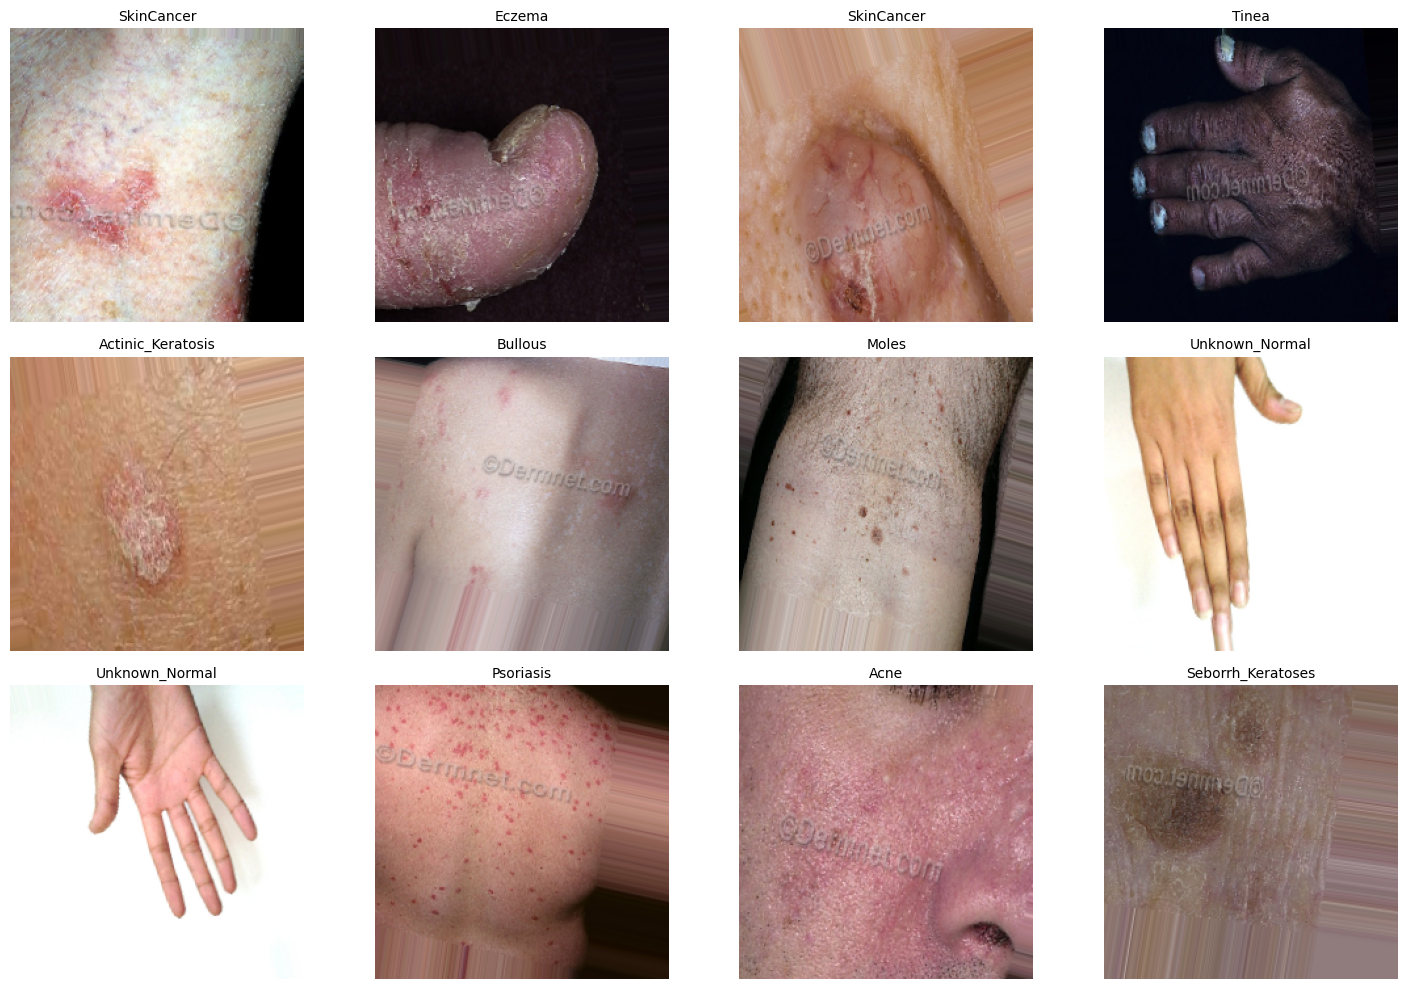

In [55]:
def plot_sample_images(generator, class_names):
    """Hiển thị một số ảnh mẫu từ generator"""
    plt.figure(figsize=(15, 10))

    # Lấy một batch ảnh
    images, labels = next(generator)


    for i in range(12):
        plt.subplot(3, 4, i + 1)
        plt.imshow(images[i])
        label_idx = np.argmax(labels[i])
        plt.title(f'{class_names[label_idx]}', fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Hiển thị ảnh từ training set
plot_sample_images(train_generator, class_names)

#BUILD MODEL CNN


In [56]:
def create_cnn_model(input_shape=(224, 224, 3), num_classes=NUM_CLASSES):
    model = keras.Sequential([
        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape), #32 filter (3x3) -> 2D ,relu(phi tuyến) bỏ âm , same -> tránh mất pixel khi tích chập
        layers.BatchNormalization(),  #Theo lô
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2), #giảm 1/2 size
        layers.Dropout(0.25), #bỏ 25% neuron -> trình overfitting

        # Block 2 -> về block sau tăng filter học sâu
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.25),

        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.25),

        # Block 4
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.25),

        # Fully Connected -> Như Deep Learning
        layers.Flatten(), #2D -> 1D
        layers.Dense(512, activation='relu'), #Them 512 neuron
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax') #số loại đầu ra , đầu ra theo xác suất từng lớp
    ])

    return model

# Tạo model
model = create_cnn_model()

#Architecture model

In [58]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 27,006,774 (103.02 MB)

 Trainable params: 27,003,318 (103.01 MB)

 Non-trainable params: 3,456 (13.50 KB)

#Callback ngay khi overfitting hoặc không cải thiện được accuracy nữa

In [59]:

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        'best_skin_disease_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]

#Thực hiện Train MODEL

In [60]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/35
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 711ms/step - accuracy: 0.1273 - loss: 3.3595
Epoch 1: val_accuracy improved from -inf to 0.12960, saving model to best_skin_disease_model.h5


348/348 ━━━━━━━━━━━━━━━━━━━━ 347s 906ms/step - accuracy: 0.1274 - loss: 3.3587 - val_accuracy: 0.1296 - val_loss: 3.4205 - learning_rate: 0.0010
Epoch 2/35
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.1964 - loss: 2.7671
Epoch 2: val_accuracy improved from 0.12960 to 0.13141, saving model to best_skin_disease_model.h5


348/348 ━━━━━━━━━━━━━━━━━━━━ 241s 691ms/step - accuracy: 0.1964 - loss: 2.7670 - val_accuracy: 0.1314 - val_loss: 2.9378 - learning_rate: 0.0010
Epoch 3/35
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - accuracy: 0.2124 - loss: 2.6436
Epoch 3: val_accuracy improved from 0.13141 to 0.18520, saving model to best_skin_disease_model.h5


348/348 ━━━━━━━━━━━━━━━━━━━━ 242s 693ms/step - accuracy: 0.2124 - loss: 2.6435 - val_accuracy: 0.1852 - val_loss: 2.7858 - learning_rate: 0.0010
Epoch 4/35
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - accuracy: 0.2456 - loss: 2.5061
Epoch 4: val_accuracy improved from 0.18520 to 0.21227, saving model to best_skin_disease_model.h5


348/348 ━━━━━━━━━━━━━━━━━━━━ 245s 703ms/step - accuracy: 0.2456 - loss: 2.5061 - val_accuracy: 0.2123 - val_loss: 2.5843 - learning_rate: 0.0010
Epoch 5/35
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.2564 - loss: 2.4508
Epoch 5: val_accuracy did not improve from 0.21227
348/348 ━━━━━━━━━━━━━━━━━━━━ 235s 676ms/step - accuracy: 0.2564 - loss: 2.4507 - val_accuracy: 0.2108 - val_loss: 2.8835 - learning_rate: 0.0010
Epoch 6/35
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 0.2716 - loss: 2.4056
Epoch 6: val_accuracy improved from 0.21227 to 0.21841, saving model to best_skin_disease_model.h5


348/348 ━━━━━━━━━━━━━━━━━━━━ 243s 697ms/step - accuracy: 0.2716 - loss: 2.4056 - val_accuracy: 0.2184 - val_loss: 2.6185 - learning_rate: 0.0010
Epoch 7/35
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.2683 - loss: 2.3814
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 7: val_accuracy improved from 0.21841 to 0.24296, saving model to best_skin_disease_model.h5


348/348 ━━━━━━━━━━━━━━━━━━━━ 250s 718ms/step - accuracy: 0.2683 - loss: 2.3814 - val_accuracy: 0.2430 - val_loss: 2.6037 - learning_rate: 0.0010
Epoch 8/35
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.2876 - loss: 2.3154
Epoch 8: val_accuracy improved from 0.24296 to 0.27256, saving model to best_skin_disease_model.h5


348/348 ━━━━━━━━━━━━━━━━━━━━ 249s 715ms/step - accuracy: 0.2876 - loss: 2.3153 - val_accuracy: 0.2726 - val_loss: 2.4263 - learning_rate: 5.0000e-04
Epoch 9/35
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.3015 - loss: 2.2561
Epoch 9: val_accuracy did not improve from 0.27256
348/348 ━━━━━━━━━━━━━━━━━━━━ 241s 694ms/step - accuracy: 0.3015 - loss: 2.2561 - val_accuracy: 0.2383 - val_loss: 2.5539 - learning_rate: 5.0000e-04
Epoch 10/35
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.3035 - loss: 2.2449
Epoch 10: val_accuracy did not improve from 0.27256
348/348 ━━━━━━━━━━━━━━━━━━━━ 248s 712ms/step - accuracy: 0.3035 - loss: 2.2449 - val_accuracy: 0.2404 - val_loss: 2.5330 - learning_rate: 5.0000e-04
Epoch 11/35
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.3007 - loss: 2.2397
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 11: val_accuracy did not improve from 0.27256
348/348 ━━━━━━━━━━━━━━━━━━━━ 244s 702ms/step - accurac

348/348 ━━━━━━━━━━━━━━━━━━━━ 251s 721ms/step - accuracy: 0.3349 - loss: 2.1245 - val_accuracy: 0.2917 - val_loss: 2.3937 - learning_rate: 2.5000e-04
Epoch 14/35
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.3428 - loss: 2.1209
Epoch 14: val_accuracy did not improve from 0.29170
348/348 ━━━━━━━━━━━━━━━━━━━━ 242s 694ms/step - accuracy: 0.3428 - loss: 2.1209 - val_accuracy: 0.2794 - val_loss: 2.4536 - learning_rate: 2.5000e-04
Epoch 15/35
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.3407 - loss: 2.1025
Epoch 15: val_accuracy did not improve from 0.29170
348/348 ━━━━━━━━━━━━━━━━━━━━ 242s 696ms/step - accuracy: 0.3407 - loss: 2.1025 - val_accuracy: 0.2917 - val_loss: 2.3966 - learning_rate: 2.5000e-04
Epoch 16/35
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.3514 - loss: 2.0786
Epoch 16: val_accuracy did not improve from 0.29170
348/348 ━━━━━━━━━━━━━━━━━━━━ 235s 675ms/step - accuracy: 0.3514 - loss: 2.0786 - val_accuracy: 0.2881 - val_loss: 2.3911 - learnin